In [1]:
import motornet as mn
from typing import Any
import torch as th
import numpy as np
import matplotlib.pyplot as plt

In [53]:
class MyCustomEnv(mn.environment.Environment):
  """A reach to a random target from a random starting position."""

  def __init__(self, *args, **kwargs):
    # pass everything as-is to the parent Environment class
    super().__init__(*args, **kwargs)
    self.__name__ = "my_custom_env"

  def reset(self, *, seed: int | None = None, ff_coefficient: float = 0., condition = "train", options: dict[str, Any] | None = None) -> tuple[Any, dict[str, Any]]:
    self._set_generator(seed)


    options = {} if options is None else options
    batch_size: int = options.get('batch_size', 1)
    joint_state: th.Tensor | np.ndarray | None = options.get('joint_state', None)
    deterministic: bool = options.get('deterministic', False)
  

    self.ff_coefficient = ff_coefficient

    if (condition=="train"): # train net to reach to random targets
      if batch_size is None:
        batch_size = 1

      joint_state = None
      goal = self.joint2cartesian(self.effector.draw_random_uniform_states(batch_size)).chunk(2, dim=-1)[0]
      self.goal = goal if self.differentiable else self.detach(goal)

    elif (condition=="test"): # centre-out reaches to each target


      angle = np.deg2rad(np.arange(0,360,45)) # 8 directions
      batch_size = len(angle)
      reaching_distance = 0.1
      
      lb = np.array(self.effector.pos_lower_bound)
      ub = np.array(self.effector.pos_upper_bound)
      start_position = lb + (ub - lb) / 2
      start_position = start_position.reshape(1,-1)
      start_jpv = th.from_numpy(np.concatenate([start_position, np.zeros_like(start_position)], axis=1)) # joint position and velocity
      start_cpv = self.effector.joint2cartesian(start_jpv).numpy()
      end_cp = reaching_distance * np.stack([np.cos(angle), np.sin(angle)], axis=-1)

      goal_states = start_cpv + np.concatenate([end_cp, np.zeros_like(end_cp)], axis=-1)
      goal_states = goal_states[:,:2]
      goal_states = goal_states.astype(np.float32)


      joint_state = th.from_numpy(np.tile(start_jpv,(batch_size,1)))
      goal = th.from_numpy(goal_states)
      self.goal = goal if self.differentiable else self.detach(goal)
      
    self.effector.reset(options={"batch_size": batch_size, "joint_state": joint_state})
  
    self.elapsed = 0.
    action = th.zeros((batch_size, self.muscle.n_muscles)).to(self.device)
  
    self.obs_buffer["proprioception"] = [self.get_proprioception()] * len(self.obs_buffer["proprioception"])
    self.obs_buffer["vision"] = [self.get_vision()] * len(self.obs_buffer["vision"])
    self.obs_buffer["action"] = [action] * self.action_frame_stacking

    obs = self.get_obs(deterministic=deterministic)
    info = {
      "states": self.states,
      "action": action,
      "noisy action": action,  # no noise here so it is the same
      "goal": self.goal,
      }
    return obs, info

  def step(self, action, deterministic: bool = False):
    self.elapsed += self.dt

    if deterministic is False:
      noisy_action = self.apply_noise(action, noise=self.action_noise)
    else:
      noisy_action = action
    
    # calculate endpoiont_load
    # self.ff_coefficient * velocity

    # add endpoiont_load
    self.effector.step(noisy_action)
    self.goal = self.goal.clone()

    obs = self.get_obs(action=noisy_action)
    reward = None
    truncated = False
    terminated = bool(self.elapsed >= self.max_ep_duration)
    info = {
      "states": self.states,
      "action": action,
      "noisy action": noisy_action,
      "goal": self.goal,
      }
    return obs, reward, terminated, truncated, info

  def get_proprioception(self):
    mlen = self.states["muscle"][:, 1:2, :] / self.muscle.l0_ce
    mvel = self.states["muscle"][:, 2:3, :] / self.muscle.vmax
    prop = th.concatenate([mlen, mvel], dim=-1).squeeze(dim=1)
    return self.apply_noise(prop, self.proprioception_noise)

  def get_vision(self):
    vis = self.states["fingertip"]
    return self.apply_noise(vis, self.vision_noise)

  def get_obs(self, action=None, deterministic: bool = False):
    self.update_obs_buffer(action=action)

    obs_as_list = [
      self.goal,
      self.obs_buffer["vision"][0],  # oldest element
      self.obs_buffer["proprioception"][0],   # oldest element
      ]
    obs = th.cat(obs_as_list, dim=-1)

    if deterministic is False:
      obs = self.apply_noise(obs, noise=self.obs_noise)
    return obs

In [41]:
class Policy(th.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, device):
        super().__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.n_layers = 1
        
        self.gru = th.nn.GRU(input_dim, hidden_dim, 1, batch_first=True)
        self.fc = th.nn.Linear(hidden_dim, output_dim)
        self.sigmoid = th.nn.Sigmoid()

        # the default initialization in torch isn't ideal
        for name, param in self.named_parameters():
            if name == "gru.weight_ih_l0":
                th.nn.init.xavier_uniform_(param)
            elif name == "gru.weight_hh_l0":
                th.nn.init.orthogonal_(param)
            elif name == "gru.bias_ih_l0":
                th.nn.init.zeros_(param)
            elif name == "gru.bias_hh_l0":
                th.nn.init.zeros_(param)
            elif name == "fc.weight":
                th.nn.init.xavier_uniform_(param)
            elif name == "fc.bias":
                th.nn.init.constant_(param, -5.)
            else:
                raise ValueError
        
        self.to(device)

    def forward(self, x, h0):
        y, h = self.gru(x[:, None, :], h0)
        u = self.sigmoid(self.fc(y)).squeeze(dim=1)
        return u, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device)
        return hidden
    
device = th.device("cpu")


effector = mn.effector.RigidTendonArm26(muscle=mn.muscle.ReluMuscle()) 
env = MyCustomEnv(effector=effector,max_ep_duration=1.,name='env')

policy = Policy(env.observation_space.shape[0], 32, env.n_muscles, device=device)
optimizer = th.optim.Adam(policy.parameters(), lr=10**-3)

In [4]:
batch_size = 32
n_batch = 6000
losses = []
interval = 250

def l1(x, y):
  """L1 loss"""
  return th.mean(th.sum(th.abs(x - y), dim=-1))

for batch in range(n_batch):
  # initialize batch
  h = policy.init_hidden(batch_size=batch_size)

  obs, info = env.reset(condition = "train", options={'batch_size':batch_size})
  terminated = False

  # initial positions and targets
  xy = [info["states"]["fingertip"][:, None, :]]
  tg = [info["goal"][:, None, :]]

  # simulate whole episode
  while not terminated:  # will run until `max_ep_duration` is reached
    action, h = policy(obs, h)
    obs, reward, terminated, truncated, info = env.step(action=action)

    xy.append(info["states"]["fingertip"][:, None, :])  # trajectories
    tg.append(info["goal"][:, None, :])  # targets

  # concatenate into a (batch_size, n_timesteps, xy) tensor
  xy = th.cat(xy, axis=1)
  tg = th.cat(tg, axis=1)
  loss = l1(xy, tg)  # L1 loss on position
  
  # backward pass & update weights
  optimizer.zero_grad() 
  loss.backward()
  th.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.)  # important!
  optimizer.step()
  losses.append(loss.item())

  if (batch % interval == 0) and (batch != 0):
    print("Batch {}/{} Done, mean policy loss: {}".format(batch, n_batch, sum(losses[-interval:])/interval))

Batch 250/6000 Done, mean policy loss: 0.4645966989994049
Batch 500/6000 Done, mean policy loss: 0.30743172150850295
Batch 750/6000 Done, mean policy loss: 0.20315125375986098
Batch 1000/6000 Done, mean policy loss: 0.16686189913749694
Batch 1250/6000 Done, mean policy loss: 0.14856896379590034
Batch 1500/6000 Done, mean policy loss: 0.13508141881227492
Batch 1750/6000 Done, mean policy loss: 0.12609213963150978
Batch 2000/6000 Done, mean policy loss: 0.12088602489233016
Batch 2250/6000 Done, mean policy loss: 0.11547834846377372
Batch 2500/6000 Done, mean policy loss: 0.11166886478662491
Batch 2750/6000 Done, mean policy loss: 0.10805217635631562
Batch 3000/6000 Done, mean policy loss: 0.10460566836595535
Batch 3250/6000 Done, mean policy loss: 0.10222182926535607
Batch 3500/6000 Done, mean policy loss: 0.10044025507569312
Batch 3750/6000 Done, mean policy loss: 0.09735278868675232
Batch 4000/6000 Done, mean policy loss: 0.0957896339893341
Batch 4250/6000 Done, mean policy loss: 0.094

In [5]:
import os
import json

weight_file = os.path.join("save", "weights")
log_file = os.path.join("save", "log.json")
cfg_file = os.path.join("save", "cfg.json")


# save model weights
th.save(policy.state_dict(), weight_file)


# save training history (log)
with open(log_file, 'w') as file:
  json.dump(losses, file)


# save environment configuration dictionary
cfg = env.get_save_config()
with open(cfg_file, 'w') as file:
  json.dump(cfg, file)


print("done.")

done.


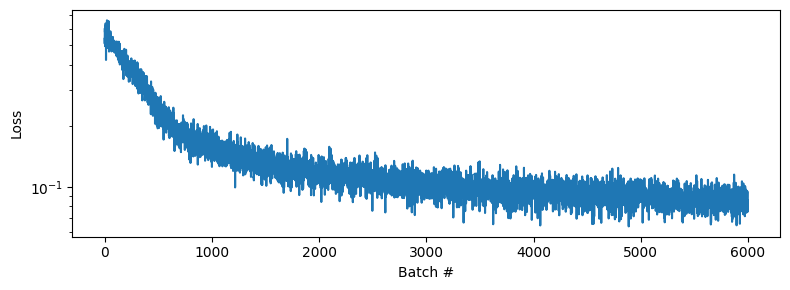

In [6]:
# retrieve and plot training history
with open(log_file, 'r') as file:
    loaded_training_log = json.load(file)


def plot_training_log(log):
  fig, axs = plt.subplots(1, 1)
  fig.set_tight_layout(True)
  fig.set_size_inches((8, 3))

  axs.semilogy(log)

  axs.set_ylabel("Loss")
  axs.set_xlabel("Batch #")
  plt.show()

plot_training_log(log=loaded_training_log)


In [54]:
env2 = MyCustomEnv(effector=mn.effector.RigidTendonArm26(muscle=mn.muscle.ReluMuscle()),max_ep_duration=1.,name='env')
policy2 = Policy(env2.observation_space.shape[0], 32, env2.n_muscles, device=device)


policy2.load_state_dict(th.load(weight_file))


<All keys matched successfully>

In [63]:
plotor = mn.plotor.plot_pos_over_time

def plot_simulations(xy, target_xy):
  target_x = target_xy[:, -1, 0]
  target_y = target_xy[:, -1, 1]

  plt.figure(figsize=(10,3))

  plt.subplot(1,2,1)
  plt.ylim([0.3, 0.65])
  plt.xlim([-0.3, 0.])
  plotor(axis=plt.gca(), cart_results=xy)
  plt.scatter(target_x, target_y)

  plt.subplot(1,2,2)
  plt.ylim([-2, 2])
  plt.xlim([-2, 2])
  plotor(axis=plt.gca(), cart_results=xy - target_xy)
  plt.axhline(0, c="grey")
  plt.axvline(0, c="grey")
  plt.xlabel("X distance to target")
  plt.ylabel("Y distance to target")
  plt.show()


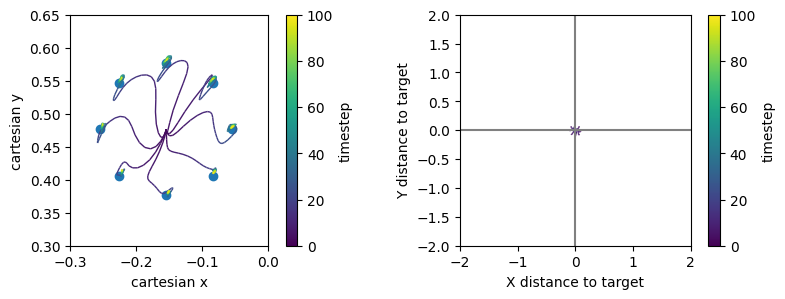

In [64]:
# ==========
# Evaluation
# ==========
batch_size = 8
# initialize batch
h = policy2.init_hidden(batch_size=batch_size)
obs, info = env2.reset(condition = "test", options={'batch_size':batch_size})
terminated = False

# initial positions and targets
xy = [info["states"]["fingertip"][:, None, :]]
tg = [info["goal"][:, None, :]]

# simulate whole episode
while not terminated:  # will run until `max_ep_duration` is reached
  action, h = policy2(obs, h)
  obs, reward, terminated, truncated, info = env2.step(action=action)

  xy.append(info["states"]["fingertip"][:, None, :])  # trajectories
  tg.append(info["goal"][:, None, :])  # targets

# concatenate into a (batch_size, n_timesteps, xy) tensor
xy = th.detach(th.cat(xy, axis=1))
tg = th.detach(th.cat(tg, axis=1))

plot_simulations(xy=xy, target_xy=tg)
